
Probabilistic Matrix Factorization for Making Personalized Recommendations
================


Igor Marfin <igor.marfin@unister.de>


Abstract
----------------




--------------------------

The model discussed in this analysis was presented in [the PyMC3 tutorial page](http://pymc-devs.github.io/pymc3/pmf-pymc/). The aim of the work is implementaion and testing the Probabilistic Matrix Factorization  model in terms of the ** Bayesian network**  with a help of the PyMC2.

More details can be found at https://bitbucket.org/iggy_floyd/probabilistic-matrix-factorization.



Motivation
-----

------------------------------


>Say I download a handbook of a hundred jokes, and I'd like to know very quickly which ones will be my favorite. So maybe I read a few, I laugh, I read a few more, I stop laughing, and I indicate on a scale of -10 to 10 how funny I thought each joke was. Maybe I do this for 5 jokes out of the 100. Now I go to the back of the book, and there's a little program included for calculating my preferences for all the other jokes. I enter in my preference numbers and shazam! The program spits out a list of all 100 jokes, sorted in the order I'll like them. 

Some thoughts
-------------------

-------------------
I split the *making recomendations* procedure in four ideas given in the tutorial:

* preparation for a recommendation: introduction of the ratings for each joke in different categories


>Normally if we want recommendations for something, we try to find people who are similar to us and ask their opinions. If Bob, Alice, and Monty are all similar to me, and they all like knock-knock jokes, I'll probably like knock-knock jokes. Now this isn't always true. It depends on what we consider to be "similar". In order to get the best bang for our buck, we really want to look for people who have the most similar sense of humor. Humor being a complex beast, we'd probably like to break it down into something more understandable. We might try to characterize each joke in terms of various factors. Perhaps jokes can be dry, sarcastic, crude, sexual, political, etc. Now imagine we go through our handbook of jokes and assign each joke a rating in each of the categories. How dry is it? How sarcastic is it? How much does it use sexual innuendos? Perhaps we use numbers between 0 and 1 for each category. Intuitively, we might call this the joke's humor profile.


* a social recommendation: make a decision using the recommendation from the closest  social individuals (based on  user-user similarity)

>Now let's suppose we go back to those 5 jokes we rated. At this point, we can get a richer picture of our own preferences by looking at the humor profiles of each of the jokes we liked and didn't like. Perhaps we take the averages across the 5 humor profiles and call this our ideal type of joke. In other words, we have computed some notion of our inherent preferences for various types of jokes. Suppose Bob, Alice, and Monty all do the same. Now we can compare our preferences and determine how similar each of us really are. I might find that Bob is the most similar and the other two are still more similar than other people, but not as much as Bob. So I want recommendations from all three people, but when I make my final decision, I'm going to put more weight on Bob's recommendation than those I get from Alice and Monty.

* an individual  recommendation: make a decision using ourselves  recommendations with the closest humor profiles (based on  item-item similarity)

>While the above procedure sounds fairly effective as is, it also reveals an unexpected additional source of information. If we rated a particular joke highly, and we know its humor profile, we can compare with the profiles of other jokes. If we find one with very close numbers, it is probable we'll also enjoy this joke. Both this approach and the one above are commonly known as neighborhood approaches. Techniques that leverage both of these approaches simultaneously are often called collaborative filtering.

* combination of the two previous recommendation strategies

>  Ideally, we'd like to use both sources of information. The idea is we have a lot of items available to us, and we'd like to work together with others to filter the list of items down to those we'll each like best. My list should have the items I'll like best at the top and those I'll like least at the bottom. Everyone else wants the same. If I get together with a bunch of other people, we all read 5 jokes, and we have some efficient computational process to determine similarity, we can very quickly order the jokes to our liking.
Formalization

*A little bit* of mathematics 
----------------------

----------------------

I begin with introduction  of some notations used later in the code.

They are $R$,$R^*$, $U$, $V$,$I$.

>Let's take some time to make the intuitive notions we've been discussing more concrete. We have a set of M jokes, or items (M=100 in our example above). We also have N people, whom we'll call users of our recommender system. For each item, we'd like to find a D dimensional factor composition (humor profile above) to describe the item. Ideally, we'd like to do this without actually going through and manually labeling all of the jokes.
Manual labeling would be both slow and error-prone, as different people will likely label jokes differently. So we model each joke as a D dimensional vector, which is its latent factor composition. Furthermore, we expect each user to have some preferences, but without our manual labeling and averaging procedure, we have to rely on the latent factor compositions to learn D dimensional latent preference vectors for each user. The only thing we get to observe is the N×M ratings matrix R provided by the users. 

* Important to remember: Entry $R_{ij}$ is the rating user $i$ gave to item $j$. 

>Many of these entries may be missing, since most users will not have rated all 100 jokes. Our goal is to fill in the missing values with predicted ratings based on the latent variables U and V. We denote the predicted ratings by $R^∗_{ij}$. 

Important to remember:  calculation of $R^∗_{ij}$ is our aim, this what we model and estimate.

> We also define an indicator matrix I, with entry $I_{ij}=0$ if $R_{ij}$ is missing and $I_{ij}=1$ otherwise.


* Important: please  *carefully* read the paragraph below

>So we have an N×D matrix of user preferences which we'll call U and an M×D factor composition matrix we'll call V. We also have a N×M rating matrix we'll call R. We can think of each row $U_i$ as indications of how much each user prefers each of the D latent factors. Each row $V_j$ can be thought of as how much each item can be described by each of the latent factors. In order to make a recommendation, we need a suitable prediction function which maps a user preference vector $U_i$ and an item latent factor vector $V_j$ to a predicted ranking. The choice of this prediction function is an important modeling decision, and a variety of prediction functions have been used. Perhaps the most common is the dot product of the two vectors, $U_i\cdot V_j$

* Important to remember: We calculate $R^∗_{ij}$  as $R^∗_{ij} =  U\cdot V^T$ 


Also you have to understand that we replace $R_{ij}$ by $R^∗_{ij}$ when we are going to make a decision on the 
recommendation of the particular joke. Why we do that?  Well, because, the matrix $R_{ij}$ usually is the 
sparse matrix with many *NaN* values and we use this minimalistic set of the data to get a fully determined 
new rating matrix $R^*_{ij}$.


Initialization 
--------------------------

________


In [1]:
import sys
sys.path = ['/usr/local/lib/python2.7/dist-packages'] + sys.path # to fix the problem with numpy: this replaces  1.6 version by 1.9

%matplotlib inline
%pylab inline


import os
import matplotlib 
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import logging
import pymc as pm

# a plotter and dataframe modules
import seaborn as  sns # seaborn to make a nice plots of the data
import pandas as pd


# use a nice style for plots and the notebook

import json
s = json.load( open("styles/my_matplotlibrc.json") )
matplotlib.rcParams.update(s)

from IPython.core.display import HTML
from IPython.display import display, Math, Latex
import urllib2


def css_styling():
    styles = open("styles/custom_v3.css", "r").read()
    return HTML(styles)
css_styling()

#HTML( urllib2.urlopen('http://bit.ly/1Bf5Hft').read() )

ion()


# Set up logging.
logger = logging.getLogger()
logger.setLevel(logging.INFO)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Data
---------------

----------------------

>The v1 Jester dataset provides something very much like the handbook of jokes we have been discussing.
At this point in time, v1 contains over 4.1 million continuous ratings in the range [-10, 10] of 100 jokes from 73,421 users. These ratings were collected between Apr. 1999 and May 2003. In order to reduce the training time of the model for illustrative purposes, 1,000 users who have rated all 100 jokes will be selected randomly. 

Let's get  our data. 

In [7]:
! mkdir data
! wget -O data/jester-dataset-v1-dense-first-1000.csv https://raw.githubusercontent.com/pymc-devs/pymc3/master/pymc3/examples/data/jester-dataset-v1-dense-first-1000.csv
! ls data    

--2015-05-28 11:10:57--  https://raw.githubusercontent.com/pymc-devs/pymc3/master/pymc3/examples/data/jester-dataset-v1-dense-first-1000.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.31.17.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.31.17.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 529543 (517K) [text/plain]
Saving to: `data/jester-dataset-v1-dense-first-1000.csv'

100%[======================================>] 529,543      352K/s   in 1.5s    

2015-05-28 11:11:00 (352 KB/s) - `data/jester-dataset-v1-dense-first-1000.csv' saved [529543/529543]

jester-dataset-v1-dense-first-1000.csv


In [2]:
data = pd.read_csv('data/jester-dataset-v1-dense-first-1000.csv')
data.head(10)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
1,-6.17,-3.54,0.44,-8.50,-7.09,-4.32,-8.69,-0.87,-6.65,-1.80,...,-3.54,-6.89,-0.68,-2.96,-2.18,-3.35,0.05,-9.08,-5.05,-3.45
2,6.84,3.16,9.17,-6.21,-8.16,-1.70,9.27,1.41,-5.19,-4.42,...,7.23,-1.12,-0.10,-5.68,-3.16,-3.35,2.14,-0.05,1.31,0.00
3,-3.79,-3.54,-9.42,-6.89,-8.74,-0.29,-5.29,-8.93,-7.86,-1.60,...,4.37,-0.29,4.17,-0.29,-0.29,-0.29,-0.29,-0.29,-3.40,-4.95
4,1.31,1.80,2.57,-2.38,0.73,0.73,-0.97,5.00,-7.23,-1.36,...,1.46,1.70,0.29,-3.30,3.45,5.44,4.08,2.48,4.51,4.66
5,9.22,9.27,9.22,8.30,7.43,0.44,3.50,8.16,5.97,8.98,...,8.11,-1.02,5.58,6.84,5.53,-5.92,8.20,8.98,-8.16,6.50
6,8.79,-5.78,6.02,3.69,7.77,-5.83,8.69,8.59,-5.92,7.52,...,2.72,-5.49,-8.59,8.69,-8.74,-3.01,8.30,-4.81,-2.38,-5.97
7,-3.50,1.55,2.33,-4.13,4.22,-2.28,-2.96,-0.49,2.91,1.99,...,3.11,1.70,0.24,-5.92,7.28,-1.36,3.74,2.82,-2.86,3.45
8,3.16,7.62,3.79,8.25,4.22,7.62,2.43,0.97,0.53,0.83,...,0.83,5.68,3.69,0.19,0.29,3.59,0.49,8.06,0.49,7.62
9,2.09,-7.57,4.17,-8.40,-6.31,5.34,-5.19,-5.05,-8.20,2.28,...,3.06,8.25,8.50,-9.51,8.45,8.16,7.82,8.50,8.35,-8.35


How many ratings do we have?

In [9]:
print '# of ratings: %d'%len(data)

# of ratings: 1000


Now we want to get the  distribution of ratings: we plot a histogram and get some statistics from it

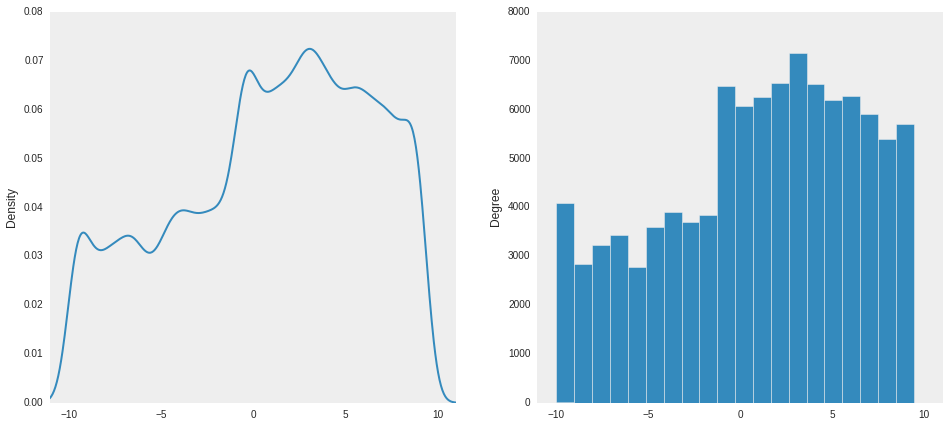

count    100000.000000
mean          0.996219
std           5.265215
min          -9.950000
25%          -2.860000
50%           1.650000
75%           5.290000
max           9.420000
dtype: float64

In [13]:
# Extract the ratings from the DataFrame
all_ratings = np.ndarray.flatten(data.values)
ratings = pd.Series(all_ratings)

# Plot a density.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
ratings.plot(kind='density', ax=ax1, grid=False)
ax1.set_ylim(0, 0.08)
ax1.set_xlim(-11, 11)

# Plot a histogram
ratings.plot(kind='hist', ax=ax2, bins=20, grid=False)
ax2.set_xlim(-11, 11)
plt.show()

# get some statistics
ratings.describe()

So we can find that the mean of all  ratings is close to 1 (almost neutral).
The distribution of mean values ( the average on the number of ratings) among jokes is

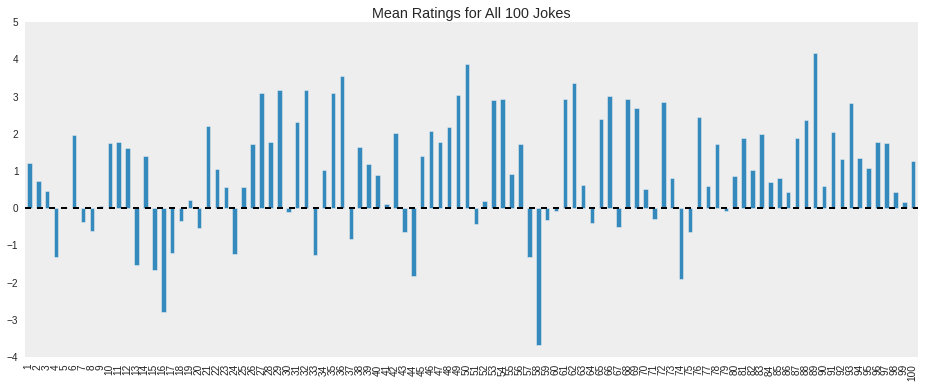

In [16]:
# mean ratings for 100 jokes
joke_means = data.mean(axis=0)
joke_means.plot(kind='bar', grid=False, figsize=(16, 6),
                title="Mean Ratings for All 100 Jokes")

While the majority of the jokes generally get positive feedback from users, there are definitely a few that stand out as poor humor. Let's take a look at the users means.


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


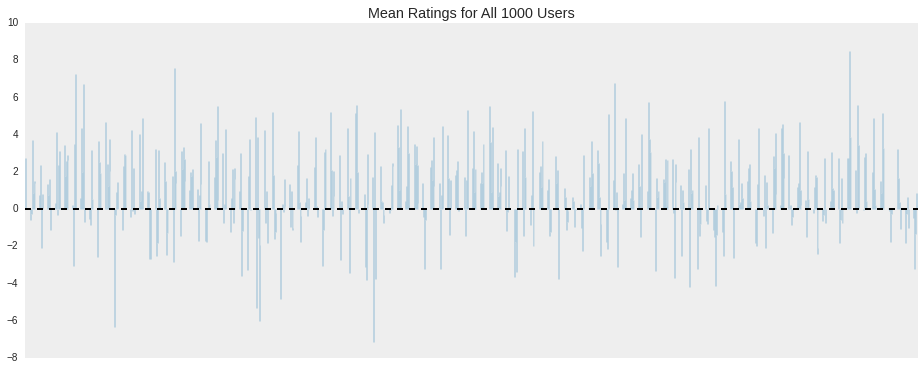

In [17]:
# user means
user_means = data.mean(axis=1)
fig, ax = plt.subplots(figsize=(16, 6))
user_means.plot(kind='bar', grid=False, ax=ax,
                title="Mean Ratings for All 1000 Users")
ax.set_xticklabels('')  # 1000 labels is nonsensical
fig.show()

We see even more significant trends here. Some users rate nearly everything highly, and some (though not as many) rate nearly everything negatively. These observations will come in handy when considering models to use for predicting user preferences on unseen jokes.

Methods
--------------------

----------------------

We're now ready to dig in and start addressing the problem. We want to predict how much each user is going to like all of the jokes he or she has not yet read, i.e. we want estimate $R^*_{ij}$.

### Baselines

----------------------------


> Every good analysis needs some kind of baseline methods to compare against. It's difficult to claim we've produced good results if we have no reference point for what defines "good". We'll define three very simple baseline methods and find the RMSE using these methods. Our goal will be to obtain lower RMSE scores with whatever model we produce


* Important to remember: Baselines are different methods to calculate $R^*_{ij}$ which are compared then.


#### Uniform Random Baseline

---------------------------------

$R^*_{ij} \sim Uniform(min\_rating,max\_rating)$


#### Global Mean Baseline

---------------------------------

$R^*_{ij} \sim global\_mean  = \frac{1}{N\times M} \sum_{i=1}^N\sum_{j=1}^M I_{ij}(R_{ij})$, where $I_{ij}$
is the  sparse mask of the $R_{ij}$.

#### Mean of the Means Baseline

---------------------------------


$R^*_{ij} = \frac{1}{3}(user\_means_i + joke\_means_j + global\_mean)$, 

$user\_means_i =\frac{1}{M} \sum_{j=1}^M I_{ij}(R_{ij}) $,

$joke\_means_j =\frac{1}{N} \sum_{i=1}^N I_{ij}(R_{ij}) $


Let's make a Baseline class which will be the abstact class for all baselines.

In [3]:
class Baseline(object):
    """Calculate baseline predictions."""

    def __init__(self, train_data):
        """Simple heuristic-based transductive learning to fill in missing
        values in data matrix."""
        self.predict(train_data.copy())

    def predict(self, train_data):
        raise NotImplementedError(
            'baseline prediction not implemented for base class')

    def rmse(self, test_data):
        """Calculate root mean squared error for predictions on test data."""

        # rmse is a global function defined later
        return rmse(test_data, self.predicted)

    
    def split_title(self,title):
        """Change "BaselineMethod" to "Baseline Method"."""
        words = []
        tmp = [title[0]]
        for c in title[1:]:
            if c.isupper():
                words.append(''.join(tmp))
                tmp = [c]
            else:
                tmp.append(c)
        words.append(''.join(tmp))
        return ' '.join(words)

    
    def __str__(self):
        return self.split_title(self.__class__.__name__)
    
    

Here we implement three basic baselines discussed previuosly.

* Uniform Random Baseline

In [4]:
class UniformRandomBaseline(Baseline):
    """Fill missing values with uniform random values."""

    def predict(self, train_data):
        
        # get the mask where 'True' indicates np.nan in the data
        nan_mask = np.isnan(train_data)
        
        # get masked_array in order to find min and max values 
        masked_train = np.ma.masked_array(train_data, nan_mask)
        
        # get min/max values for uniform distribution
        pmin, pmax = masked_train.min(), masked_train.max()
        
        # ge the number of 'True' in the mask
        N = nan_mask.sum()
        
        #replace all np.nan in the pandas dataframe by the uniformly generated value
        train_data[nan_mask] = np.random.uniform(pmin, pmax, N)
        self.predicted = train_data


* Global Mean Baseline

In [5]:
class GlobalMeanBaseline(Baseline):
    """Fill in missing values using the global mean."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        train_data[nan_mask] = train_data[~nan_mask].mean()
        self.predicted = train_data

* Mean of the Means Baseline

In [6]:
class MeanOfMeansBaseline(Baseline):
    """Fill in missing values using mean of user/item/global means."""

    def predict(self, train_data):
        
        # get a mask
        nan_mask = np.isnan(train_data)
        
        # get a masked_array  to find out min, max, mean values.    
        masked_train = np.ma.masked_array(train_data, nan_mask)
        
        # the global mean: a mean value of the masked_array
        global_mean = masked_train.mean()
        
        # using different axis, we can get 'user' and 'joke' means
        user_means = masked_train.mean(axis=1) # among jokes of one user
        joke_means = masked_train.mean(axis=0) # among users
        self.predicted = train_data.copy()
        n, m = train_data.shape
        for i in xrange(n):
            for j in xrange(m):
                if np.ma.isMA(joke_means[j]): # it return true if joke_means[j] doesn't contain np.nan
                    self.predicted[i,j] = np.mean(
                        (global_mean, user_means[i]))
                else:
                    self.predicted[i,j] = np.mean(
                        (global_mean, user_means[i], joke_means[j]))


Now, let's put all baselines in one dictionary, in order to test them later

In [7]:
from collections import OrderedDict
baseline_methods = OrderedDict()
baseline_methods['ur'] = UniformRandomBaseline
baseline_methods['gm'] = GlobalMeanBaseline
baseline_methods['mom'] = MeanOfMeansBaseline

RMSE
--------------------

----------------------


We're now ready to dig in and start addressing the problem. We want to predict how much each user is going to like all of the jokes he or she has not yet read, i.e. we want estimate $R^*_{ij}$.
The way we are going to use in order to test baselines and PMF bayesian framework is very simple:

* we will use the RMSE (root mean squared error) for predictions on test data 
* and the method with the smallest RMSE would be defined as the best


$RMSE = \sqrt{\frac{ \sum_{i=1}^N\sum_{j=1}^M I_{ij}(R_{ij}-R^*_{ij})^2}{\sum_{i=1}^N\sum_{j=1}^M I_{ij}}}$


* Important to understand: the we use the test data to calculate $RMSE$. 

In [8]:
# Define our evaluation function.
def rmse(test_data, predicted):
      
    """Calculate root mean squared error.
    Ignoring missing values in the test data.
    """
    I = ~np.isnan(test_data)   # indicator for missing values
    N = I.sum()                # number of non-missing values
    sqerror = abs(test_data - predicted) ** 2  # squared error array
    mse = sqerror[I].sum() / N                 # mean squared error
    return np.sqrt(mse)  

Train/Test  data
-----------------------------

--------------

Originally, authors of the tutorial say:

> So we produce a test set by taking a random sample of the cells in the full N×M data matrix $R_{ij}$.
The values selected as test samples are replaced with nan values in a copy of the original data matrix to produce the training set.
Since we'll be producing random splits, let's also write out the train/test sets generated. This will allow us to replicate our results. We'd like to be able to idenfity which split is which, so we'll take a hash of the indices selected for testing and use that to save the data.

But do you understand this statement properly?
I will try to summarize all points here:

* Use the origianl $R_{ij}$ uploaded at the beginning.
* Then randomly choose N cells in $R_{ij}$ and replace them by np.nan. This is a train dataset.
* The origianl $R_{ij}$  is a test dataset.
* Then create a hash code for chosen indexes and store it to the file.
* We can later to replicate the train/test splitting using this hash code.


In [9]:
import hashlib


try:
    import ujson as json
except ImportError:
    import json


# First, define functions to save our parameters to the file.
def save_np_vars(vars, savedir):
    """Save a dictionary of numpy variables to `savedir`. We assume
    the directory does not exist; an OSError will be raised if it does.
    """
    logging.info('writing numpy vars to directory: %s' % savedir)
    os.mkdir(savedir)
    shapes = {}
    for varname in vars:
        data = vars[varname]
        var_file = os.path.join(savedir, varname + '.txt')
        np.savetxt(var_file, data.reshape(-1, data.size))
        shapes[varname] = data.shape

        ## Store shape information for reloading.
        shape_file = os.path.join(savedir, 'shapes.json')
        with open(shape_file, 'w') as sfh:
            json.dump(shapes, sfh)

# Define the function to upload our parameters from the file
def load_np_vars(savedir):
    """Load numpy variables saved with `save_np_vars`."""
    shape_file = os.path.join(savedir, 'shapes.json')
    with open(shape_file, 'r') as sfh:
        shapes = json.load(sfh)

    vars = {}
    for varname, shape in shapes.items():
        var_file = os.path.join(savedir, varname + '.txt')
        vars[varname] = np.loadtxt(var_file).reshape(shape)

    return vars            
            

# Define a function for splitting train/test data.
def split_train_test(data, percent_test=0.1):
    """Split the data into train/test sets.
    :param int percent_test: Percentage of data to use for testing. Default 10%.
    """
    n, m = data.shape             # num. of users, num. of jokes
    N = n * m                     # num. of cells in matrix
    test_size = N * percent_test  # use 10% of data as test set
    train_size = N - test_size    # and remainder for training

    
    # Prepare train/test ndarrays.
    train = data.copy().values # original Rij's values -> this is our 'train' dataset    
    test = np.ones(train.shape) * np.nan # our 'test' dataset is the Rij matrix with np.nan everywhere 

    
    # Draw random sample of training data to use for testing.
    #tosample = np.where(~np.isnan(train))       # ignore u nan values in data

    tosample = (~np.isnan(train)).nonzero()      #  nonzero() return a pair of indexes for non np.nan values

    
    idx_pairs = zip(tosample[0], tosample[1])   # tuples of row/col index pairs

    
    indices = np.arange(len(idx_pairs))         # indices of index pairs
    
    
    sample = np.random.choice(indices, replace=False, size=test_size) # here we use the sampling scheme without replacement

    
    # Transfer random sample from train set to test set.
    for idx in sample:
        idx_pair = idx_pairs[idx]
        test[idx_pair] = train[idx_pair]  # transfer to test set
        train[idx_pair] = np.nan          # remove from train set

    # Verify everything worked properly
    
    # what we have now:  the train dataset contains np.nan at positions defined by the randomly selected indexes
    # the test dataset has all defined values at these positions but others are np.nan
    assert(np.isnan(train).sum() == test_size)
    assert(np.isnan(test).sum() == train_size)

    # Finally, hash the indices and save the train/test sets.
    index_string = ''.join(map(str, np.sort(sample)))
    name = hashlib.sha1(index_string).hexdigest()

    # saving train/test datasets to the folder 'name' 
    savedir = os.path.join('data', name)
    save_np_vars({'train': train, 'test': test}, savedir)

    print 'train/test datsets were stored in %s folder'%savedir
    
    # Return train set, test set, and unique hash of indices.
    return train, test, name


# Finally, define the function to upload 
def load_train_test(name):
    """Load the train/test sets."""
    savedir = os.path.join('data', name)
    vars = load_np_vars(savedir)
    return vars['train'], vars['test']

Later, we are going to use Bayesian approach to calculate Probability Matrix $R_{ij}$. 
Becasuse, we intend  to use D=5, the dimension  for hidden variables, it will bring D(N + M) = 5500 
latent variables. It will take a huge memory to process the model.

So, we restrict ourselves to 50 users, and 20 jokes:

In [10]:
data = pd.read_csv('data/jester-dataset-v1-dense-first-1000.csv')
data = data.loc[:50,data.columns.values[:20]]


In [11]:
# test of splitting 
train, test, split_hash = split_train_test(data)
train_reload, test_reload = load_train_test(split_hash)
assert(np.isnan(train).sum() == np.isnan(train_reload).sum()  )
assert(np.isnan(test).sum() == np.isnan(test_reload).sum()  )


INFO:root:writing numpy vars to directory: data/9707154a0142b6aa18153ba96ee20c36f647bbf8


train/test datsets were stored in data/9707154a0142b6aa18153ba96ee20c36f647bbf8 folder


Performance of the Baselines
---------------------------------


---------------

Now we can train our baselines, calculate their RMSE and compare them

Uniform Random Baseline RMSE:	8.21210
Global Mean Baseline RMSE:	4.99941
Mean Of Means Baseline RMSE:	4.76052


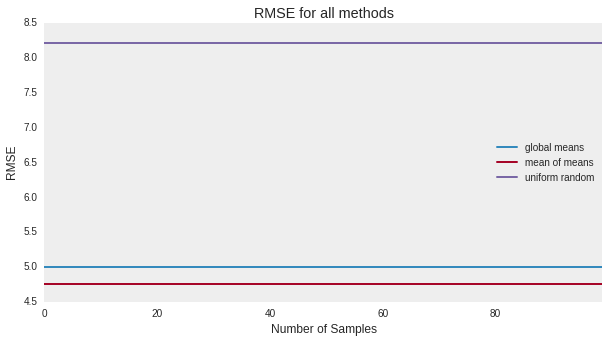

In [12]:
# Let's see the results:
train, test = load_train_test(split_hash)

baselines = {}
for name in baseline_methods:
    Method = baseline_methods[name]
    method = Method(train)
    baselines[name] = method.rmse(test)
    print '%s RMSE:\t%.5f' % (method, baselines[name])
    
    
# let's plot results   
size = 100
results = pd.DataFrame({
    'uniform random': np.repeat(baselines['ur'], size),
    'global means': np.repeat(baselines['gm'], size),
    'mean of means': np.repeat(baselines['mom'], size),
})
fig, ax = plt.subplots(figsize=(10, 5))
results.plot(kind='line', grid=False, ax=ax,
                 title='RMSE for all methods')
ax.set_xlabel("Number of Samples")
ax.set_ylabel("RMSE")

Probabilistic Matrix Factorization
-----------------------

------------------


>Probabilistic Matrix Factorization (PMF) [3] is a probabilistic approach to the collaborative filtering problem that takes a Bayesian perspective. The ratings R are modeled as draws from a Gaussian distribution. The mean for $R_{ij}$ is $U_i\cdot V^T_j$. The precision α is a fixed parameter that reflects the uncertainty of the estimations; the normal distribution is commonly reparameterized in terms of precision, which is the inverse of the variance. Complexity is controlled by placing zero-mean spherical Gaussian priors on U and V. 


In other words, each $i^{th}$ row of $U$ is drawn from a multivariate Gaussian with mean $\mu_U=0$ and precision $\alpha_U$ which is some multiple of the identity matrix I. 
Each $j^{th}$ row of $V$ is drawn from a multivariate Gaussian with mean $\mu_V=0$ and precision $\alpha_V$ which is some multiple of the identity matrix I.


Let's try to define the class realizing the model of PMF

In [13]:
class PMF(object):
    """Probabilistic Matrix Factorization model using pymc3."""

    def __init__(self, train, dim, alpha=2, std=0.01, bounds=(-10, 10)):
        """Build the Probabilistic Matrix Factorization model using pymc2.

        :param np.ndarray train: The training data to use for learning the model.
        :param int dim: Dimensionality of the model; number of latent factors.
        :param int alpha: Fixed precision for the likelihood function.
        :param float std: Amount of noise to use for model initialization.
        :param (tuple of int) bounds: (lower, upper) bound of ratings.
            These bounds will simply be used to cap the estimates produced for R.

        """
        self.dim = dim
        self.alpha = alpha
        self.std = np.sqrt(1.0 / alpha)
        self.bounds = bounds
        # occupy a lot of memory
        #self.data = train.copy()
        self.data = train
        n, m = self.data.shape

        # Perform mean value imputation
        nan_mask = np.isnan(self.data)
        self.data[nan_mask] = self.data[~nan_mask].mean()

        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        # var() gives std. variation
        self.alpha_u = 1 / self.data.var(axis=1).mean()
        self.alpha_v = 1 / self.data.var(axis=0).mean()

        # Specify the model.
        logging.info('building the PMF model')
        
        # define our bayesian model here
      
        
        # define the U_i vector 
        self.Ui = [pm.MvNormal('U%i'%i,np.zeros(dim),self.alpha_u * np.eye(dim)) for i in range(n) ]

        # define the V_j vector
        self.Vj = [pm.MvNormal('V%i'%j,np.zeros(dim),self.alpha_v * np.eye(dim)) for j in range(m) ]
        
        # define the mean value 
        Rij=[]        
        for i in range(n):
            _tmp=[]
            for j in range(m):
                _tmp +=[pm.Lambda('_R%i%i'%(i,j),lambda U=self.Ui[i],V=self.Vj[j]: np.dot(U,V.T))]
            Rij+=[_tmp]
        
        
     
        
        # define the observed 
        self.Rij=[]
        
        for i in range(n):
            _tmp=[]
            for j in range(m):
                #_tmp +=[pm.Normal('R%i%i'%(i,j),np.dot(self.Ui[i].value,self.Vj[j].value.T),self.alpha,value=self.data[i,j],observed=True)]
                _tmp +=[pm.Normal('R%i%i'%(i,j),Rij[i][j],self.alpha,value=self.data[i,j],observed=True)]
            self.Rij+=[_tmp]

        self.Rij = np.array(self.Rij).flatten().tolist()
        
        
        # define our model        
        self.model = pm.Model(self.Ui + self.Vj  + self.Rij )
        
       

        logging.info('done building the PMF model') 
        

    def __str__(self):
        return self.name

In [14]:
# Test of Bayesian PMF

# We use a fixed precision for the likelihood.
# This reflects uncertainty in the dot product.
# We choose 2 in the footsteps Salakhutdinov
# Mnihof.
ALPHA = 2

# The dimensionality D; the number of latent factors.
# We can adjust this higher to try to capture more subtle
# characteristics of each joke. However, the higher it is,
# the more expensive our inference procedures will be.
# Specifically, we have D(N + M) latent variables. For our
# Jester dataset, this means we have D(1100), so for 5
# dimensions, we are sampling 5500 latent variables.
DIM = 5


pmf = PMF(train, DIM, ALPHA, std=0.05)
? pmf



INFO:root:building the PMF model
INFO:root:done building the PMF model


Ok. Let's make some tunning of our PMF class. First, we add 'MAP' (maximum a posteriori)  property and functionality to read it and save it to the file

In [15]:
import scipy as sp
import time

# Now define the MAP estimation infrastructure.

# property 'map_dir'
def _map_dir(self):
    ''' return the dir name where we store the MAP'''
    basename = 'pmf-map-d%d' % self.dim
    return os.path.join('data', basename)


# support for the property 'map'
def _find_map(self):
    """Find mode of posterior using Powell optimization."""
    tstart = time.time()
    logging.info('finding PMF MAP using Powell optimization...')
    self._map = pm.MAP(self.model)
    self._map.fit()

    elapsed = int(time.time() - tstart)
    logging.info('found PMF MAP in %d seconds' % elapsed)

    
    
    #pymc2
    # This is going to take a good deal of time to find, so let's save it.
    savedir = os.path.join('data', name)
    map_to_save={}    
    for var in list(self._map.variables):
        map_to_save.update({str(var):var.value})
        
    self._map =  map_to_save   
    save_np_vars(self._map, self.map_dir)
    
    print 'MAP was stored in %s folder'%savedir



    
# support for the property 'map'    
def _load_map(self):
    

    self._map = load_np_vars(self.map_dir)
    

    
def _map(self):
    try:
        return self._map
    except:
        if os.path.isdir(self.map_dir):
            self.load_map()
        else:
            self.find_map()
        return self._map    
    
    
# Update our class with the new MAP infrastructure.
PMF.find_map = _find_map
PMF.load_map = _load_map
PMF.map_dir = property(_map_dir)
PMF.map = property(_map)    

Let's try to find MAP

In [ ]:
pmf.load_map()

In [130]:
# Find MAP for PMF.
#pmf.find_map()

INFO:root:finding PMF MAP using Powell optimization...
INFO:root:found PMF MAP in 435 seconds
INFO:root:writing numpy vars to directory: data/pmf-map-d5


MAP was stored in data/mom folder


In [132]:
print pmf.map['U0']

[ 2.61198177  0.03008766 -0.46349007  1.78042112 -2.81458536]


Now we would like to introduce the MCMC sampling

In [41]:
# Draw MCMC samples.
def _trace_dir(self):
    basename = 'pmf-mcmc-d%d' % self.dim
    return os.path.join('data', basename)



# Sampler 
def _draw_samples(self, nsamples=1000, njobs=2):
    # First make sure the trace_dir does not already exist.
    if os.path.isdir(self.trace_dir):
        raise OSError(
            'trace directory %s already exists. Please move or delete.' % self.trace_dir)

    # pymc2
    logging.info('drawing %d samples using %d jobs' % (nsamples, njobs))
    self.mcmc =pm.MCMC(self.model,db='txt',dbname=self.trace_dir)    
    logging.info('backing up trace to directory: %s' % self.trace_dir)
    self.mcmc.sample(nsamples)
    self.traces={}
    
    for var in list(self.mcmc.stochastics):
        self.traces.update(
                            { str(var):self.mcmc.trace(str(var))[:] }                        
                        )
    
    self.mcmc.db.close()
   
    
def _load_trace(self):
    self.mcmc = pm.MCMC(self.model,db=pm.database.txt.load(self.trace_dir))     
    
    self.traces={}
    for var in list(self.mcmc.stochastics):
        self.traces.update(
                            { str(var):self.mcmc.trace(str(var))[:] }                        
                        )    
 

In [42]:
# Update our class with the sampling infrastructure.
PMF.trace_dir = property(_trace_dir)
PMF.draw_samples = _draw_samples
PMF.load_trace = _load_trace

Let's try to MCMC

In [21]:
pmf.draw_samples(5000, njobs=3)

INFO:root:drawing 5000 samples using 3 jobs
INFO:root:backing up trace to directory: data/pmf-mcmc-d5


 [-----------------100%-----------------] 5000 of 5000 complete in 152.4 sec

In [46]:
pmf.load_trace()


Finally, we need to define the 'predict' function. For user $i$ and joke $j$, a prediction is generated by drawing from $N(U_i\cdot V^T_j,\alpha)$. To generate predictions from the sampler, we generate an $R_{ij}$ matrix for each $U$ and $V$ sampled, then we combine these by averaging over the $K$ samples.
We introduce two versions of the 'predict': 

* One version with averaging:   $P(R^*_{ij}|R,\alpha,\alpha_U,\alpha_V) = \frac{1}{K}\sum_{k=1}^K N(U_i\cdot V^T_j,\alpha)$

* Another version w/o averaging: $P(R^*_{ij}|R,\alpha,\alpha_U,\alpha_V) = N(U_i\cdot V^T_j,\alpha)$

The version of $P(R^*_{ij}|R,\alpha,\alpha_U,\alpha_V)$ w/o  averaging will be used in  the diagnostics where
diagnostic code will do averaging piece during evaluation. 

In [118]:

# version w/o averaging
def _predict(self, U, V):
    """Estimate R from the given values of U and V."""
    R = np.dot(U, V.T)
    n, m = R.shape
    sample_R = np.array([
        [np.random.normal(R[i,j], self.std) for j in xrange(m)]
        for i in xrange(n)
    ])

    # bound ratings
    low, high = self.bounds
    sample_R[sample_R < low] = low
    sample_R[sample_R > high] = high
    return sample_R


# version w/ averaging
def _predict_trace(self, trace_U, trace_V):
    """Estimate R from the given traces  of U and V."""
    
    R = np.zeros(self.data.shape)
    for sample in range(len(trace_U)):
        sample_R=self.predict(trace_U[sample],trace_V[sample])
        
        
        R += sample_R
        running_R = R / (sample + 1)


    return    running_R

# here we define a function which construct a matrix 'U' from  the list of 'U%i' 
def _getTraceMatrices(self):
    ''' construct the numpy.ndarray from the list of stochatisc variables for all traces'''
    
    Ui_names = map(lambda x:str(x),self.Ui)
    Vj_names = map(lambda x:str(x),self.Vj)
    

    _tmp_Ui={}
    _tmp_Vj={}
    nsample=None
    
    for i in Ui_names:
        _tmp_Ui.update(
                {
                    i:[ self.traces[i][j] for j in range(len(self.traces[i])) ]
                }            
            )
        if nsample is None: nsample = len(self.traces[i])

    for j in Vj_names:
        _tmp_Vj.update(
                {
                    j:[ self.traces[j][i] for i in range(len(self.traces[j])) ]
                }            
            )
            
    Ui=[]    
    Vj=[]    
    

    for i in range(nsample):
        _tmp_Ui_list=[]
        for row in Ui_names:
             _tmp_Ui_list+=[_tmp_Ui[row][i]]
                
        Ui+=[np.array(_tmp_Ui_list)]

        _tmp_Vj_list=[]
        for row in Vj_names:
             _tmp_Vj_list+=[_tmp_Vj[row][i]]
        Vj+=[np.array(_tmp_Vj_list)]

        
    return Ui,Vj

    
# Update our class with the new Predict infrastructure
PMF.getTraceMatrices = _getTraceMatrices    
PMF.predict =_predict
PMF.predict_trace =_predict_trace

Test of the predict function

In [120]:
traces_U,traces_V=pmf.getTraceMatrices()
print '10 th sample R : ',pmf.predict(traces_U[9],traces_V[9])
print '\n\n'
print 'averaging sampled R:',pmf.predict_trace(traces_U,traces_V)

10 th sample R :  [[ 0.73738038  2.8829047   4.15213768 ...,  0.90930744 -0.54034526
  -1.37353771]
 [-4.66542936 -4.84431165 -4.0234287  ..., -3.47845611 -1.78232155
  -3.3289911 ]
 [ 0.08347473 -0.16927429 -0.73111556 ..., -5.42224673 -4.75400413
  -0.97107831]
 ..., 
 [ 5.9403842   1.0674877   8.3158795  ..., -3.92076744  2.43819077
  -4.45348299]
 [-3.40283744 -5.17037176 -3.23143203 ...,  0.55740903 -0.50587615
   1.70313551]
 [ 1.8666256   2.66123111  3.16467822 ...,  0.16980542  1.15414995
  -1.67072825]]



averaging sampled R: [[ 1.02171491  2.42804436  2.90836343 ...,  1.94257543  1.57047715
  -1.95718612]
 [-5.9003429  -5.91843978 -3.78319629 ..., -3.51430279 -2.18267165
  -2.83427926]
 [ 1.18093384  0.24779066 -0.47771771 ..., -6.11247345 -5.17088762
  -0.2462697 ]
 ..., 
 [ 6.47288567  1.26964384  9.11230926 ..., -4.53319801  1.32721136
  -4.26946043]
 [-2.95453856 -5.68951228 -2.75327014 ...,  1.02271064 -0.76349737
   0.14336738]
 [ 2.44892463  1.68377936  3.6400361  ...

Diagnostics and Posterior Predictive Check
---------------------------------

---------------

>The next step is to check how many samples we should discard as burn-in. Normally, we'd do this using a traceplot to get some idea of where the sampled variables start to converge. In this case, we have high-dimensional samples, so we need to find a way to approximate them. One way was proposed by Salakhutdinov and Mnih, p.886. We can calculate the Frobenius norms of U and V at each step and monitor those for convergence. This essentially gives us some idea when the average magnitude of the latent variables is stabilizing. The equations for the Frobenius norms of U and V are shown below. We will use numpy's linalg package to calculate these.

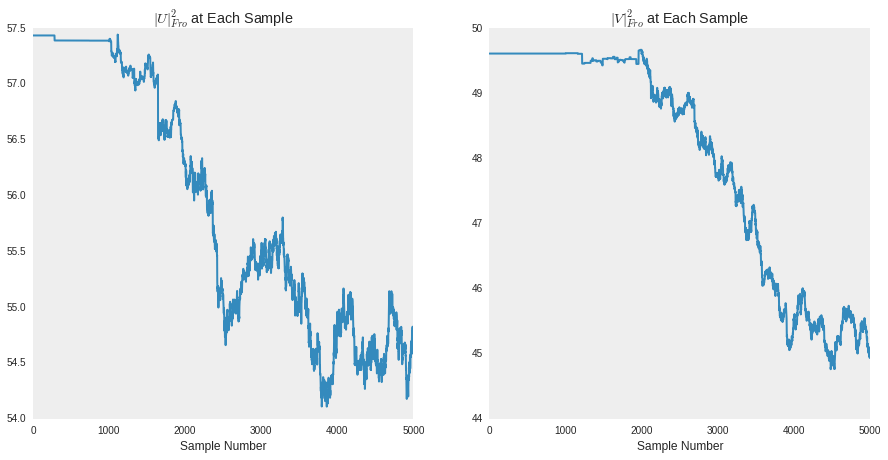

In [125]:
def _norms(pmf_model, ord='fro'):
    """Return norms of latent variables at each step in the
    sample trace. These can be used to monitor convergence
    of the sampler.
    """
    
    
    traces_U,traces_V=pmf_model.getTraceMatrices()
    
    norms = {'U':traces_U,               
               'V':traces_V
              }
    for var in norms:
        norms[var] = map(lambda x: np.linalg.norm(x, ord),norms[var])
    return norms


def _traceplot(pmf_model):
    """Plot Frobenius norms of U and V as a function of sample #."""
    trace_norms = pmf_model.norms()
    u_series = pd.Series(trace_norms['U'])
    v_series = pd.Series(trace_norms['V'])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    u_series.plot(kind='line', ax=ax1, grid=False,
                  title="$\|U\|_{Fro}^2$ at Each Sample")
    v_series.plot(kind='line', ax=ax2, grid=False,
                  title="$\|V\|_{Fro}^2$ at Each Sample")
    ax1.set_xlabel("Sample Number")
    ax2.set_xlabel("Sample Number")
    
    
PMF.norms = _norms
PMF.traceplot = _traceplot    
pmf.traceplot()

It appears we get convergence of U and V after about 4000 samples.

Let's also do a traceplot of the RSME. We'll compute RMSE for both the train and the test set, even though the convergence is indicated by RMSE on the training set alone. In addition, let's compute a running RMSE on the train/test sets to see how aggregate performance improves or decreases as we continue to sample.

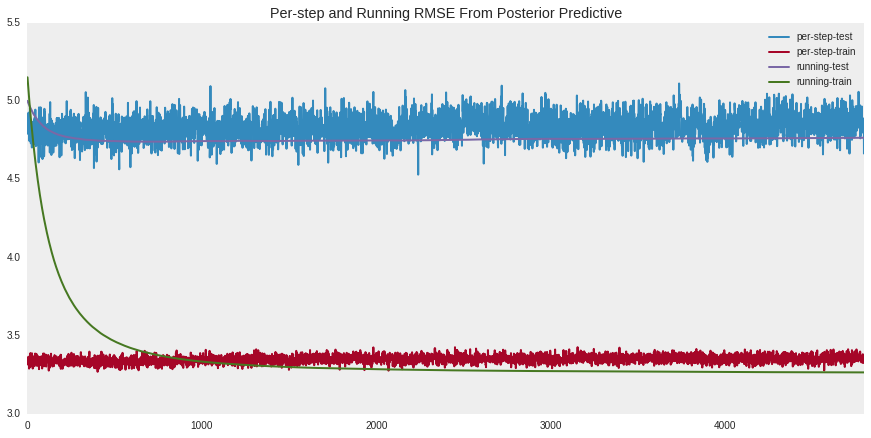

In [138]:
def _running_rmse(pmf_model, test_data, train_data, burn_in=0, plot=True):
    """Calculate RMSE for each step of the trace to monitor convergence.
    """
    
    traces_U,traces_V=pmf_model.getTraceMatrices()
    burn_in = burn_in if len(traces_U) >= burn_in else 0
    results = {'per-step-train': [], 'running-train': [],
               'per-step-test': [], 'running-test': []}

    R = np.zeros(test_data.shape)
    
    
    
    for cnt in range(burn_in,len(traces_U)):
        sample_R = pmf_model.predict(traces_U[cnt], traces_V[cnt])
        R += sample_R
        running_R = R / (cnt + 1)
        results['per-step-train'].append(rmse(train_data, sample_R))
        results['running-train'].append(rmse(train_data, running_R))
        results['per-step-test'].append(rmse(test_data, sample_R))
        results['running-test'].append(rmse(test_data, running_R))

    results = pd.DataFrame(results)

    if plot:
        results.plot(
            kind='line', grid=False, figsize=(15, 7),
            title='Per-step and Running RMSE From Posterior Predictive')

    # Return the final predictions, and the RMSE calculations
    return running_R, results


PMF.running_rmse = _running_rmse

predicted, results = pmf.running_rmse(test, train, burn_in=200)

Excellent. Another thing we want to do is make sure the MAP estimate we obtained is reasonable. We can do this by computing RMSE on the predicted ratings obtained from the MAP values of U and V. 

In [133]:

# here we define a function which construct a matrix 'U' from  the list of 'U%i' 
def _getMAPMatrices(self):
    ''' construct the numpy.ndarray from the list of stochatisc variables for all traces'''
    
    Ui_names = map(lambda x:str(x),self.Ui)
    Vj_names = map(lambda x:str(x),self.Vj)
    

    _tmp_Ui={}
    _tmp_Vj={}
    
    for i in Ui_names:
        _tmp_Ui.update(
                {
                    i:self.map[i]
                }            
            )
        

    for j in Vj_names:
        _tmp_Vj.update(
                {
                    j:self.map[j]
                }            
            )
            
    _tmp_Ui_list=[]
    for row in Ui_names:
             _tmp_Ui_list+=[_tmp_Ui[row]]
                
    Ui=np.array(_tmp_Ui_list)

    _tmp_Vj_list=[]
    for row in Vj_names:
             _tmp_Vj_list+=[_tmp_Vj[row]]
    Vj=np.array(_tmp_Vj_list)

        
    return Ui,Vj


# estimation of the MAP performance
def _eval_map(pmf_model, train, test):
    U,V = pmf_model.getMAPMatrices()

    # Make predictions and calculate RMSE on train & test sets.
    predictions = pmf_model.predict(U, V)
    train_rmse = rmse(train, predictions)
    test_rmse = rmse(test, predictions)
    overfit = test_rmse - train_rmse

    # Print report.
    print 'PMF MAP training RMSE: %.5f' % train_rmse
    print 'PMF MAP testing RMSE:  %.5f' % test_rmse
    print 'Train/test difference: %.5f' % overfit

    return test_rmse


# Add eval function to PMF class.
PMF.getMAPMatrices = _getMAPMatrices
PMF.eval_map = _eval_map


In [134]:
# Evaluate PMF MAP estimates.
pmf_map_rmse = pmf.eval_map(train, test)
pmf_improvement = baselines['mom'] - pmf_map_rmse
print 'PMF MAP Improvement:   %.5f' % pmf_improvement

PMF MAP training RMSE: 3.31098
PMF MAP testing RMSE:  4.92116
Train/test difference: 1.61018
PMF MAP Improvement:   -0.16064


Let's compare the MAP results with MCMC ones:

In [135]:
# And our final RMSE?
final_test_rmse = results['running-test'].values[-1]
final_train_rmse = results['running-train'].values[-1]
print 'Posterior predictive train RMSE: %.5f' % final_train_rmse
print 'Posterior predictive test RMSE:  %.5f' % final_test_rmse
print 'Train/test difference:           %.5f' % (final_test_rmse - final_train_rmse)
print 'Improvement from MAP:            %.5f' % (pmf_map_rmse - final_test_rmse)
print 'Improvement from Mean of Means:  %.5f' % (baselines['mom'] - final_test_rmse)

Posterior predictive train RMSE: 3.26451
Posterior predictive test RMSE:  4.76826
Train/test difference:           1.50375
Improvement from MAP:            0.15290
Improvement from Mean of Means:  -0.00774


Summary of Results
---------------------

--------------

Let's summarize our results.

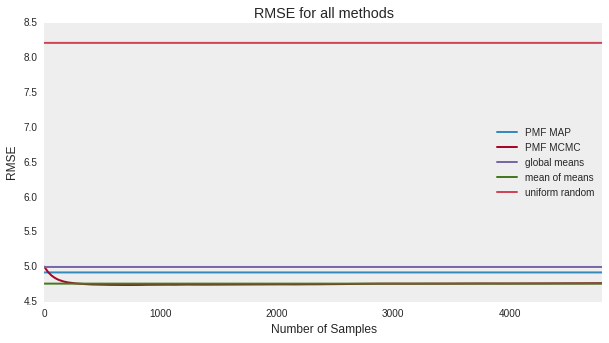

In [141]:
# let's plot results   
size = 4800
final_results = pd.DataFrame({
    'uniform random': np.repeat(baselines['ur'], size),
    'global means': np.repeat(baselines['gm'], size),
    'mean of means': np.repeat(baselines['mom'], size),
    'PMF MAP': np.repeat(pmf_map_rmse, size),
    'PMF MCMC': results['running-test'][:size]
        
})

fig, ax = plt.subplots(figsize=(10, 5))
final_results.plot(kind='line', grid=False, ax=ax,
                 title='RMSE for all methods')
ax.set_xlabel("Number of Samples")
ax.set_ylabel("RMSE")

>Our results demonstrate that the mean of means method is our best baseline on our prediction task.  We illustrated one way to monitor convergence of an MCMC sampler with a high-dimensionality sampling space using the Frobenius norms of the sampled variables. The traceplots using this method seem to indicate that our sampler converged to the posterior. Results using this posterior showed that attempting to improve the  estimation using MCMC sampling actually overfit the training data and increased test RMSE. This was likely caused by the constraining of the posterior via fixed precision parameters $\alpha$, $\alpha_U$, and $\alpha_V$.

To solve the problem of the overfitting, perhaps, we could implement the fully Bayesian version of PMF (BPMF).
which places hyperpriors on the model parameters to automatically learn ideal mean and precision parameters for U and V. This would likely resolve the issue we faced in this analysis. 
We would expect BPMF to improve upon the MAP estimation produced here by learning more suitable hyperparameters and parameters.

Fully Bayesian Probabilistic Matrix Factorization(FBPMF) (optional)
------------

--------------


It was inspired by the [gist](https://gist.github.com/macks22/00a17b1d374dfc267a9a).

In [158]:
class FBPMF(object):
    """Fully Bayesian Probabilistic Matrix Factorization model using pymc2."""

    def __init__(self, train, dim, alpha=2, std=0.01, bounds=(-10, 10)):
        """Build the Probabilistic Matrix Factorization model using pymc2.

        :param np.ndarray train: The training data to use for learning the model.
        :param int dim: Dimensionality of the model; number of latent factors.
        :param int alpha: Fixed precision for the likelihood function.
        :param float std: Amount of noise to use for model initialization.
        :param (tuple of int) bounds: (lower, upper) bound of ratings.
            These bounds will simply be used to cap the estimates produced for R.

        """
        self.dim = dim
        self.alpha = alpha
        self.std = np.sqrt(1.0 / alpha)
        self.bounds = bounds
        # occupy a lot of memory
        #self.data = train.copy()
        self.data = train
        n, m = self.data.shape
        beta_0 = 1  # scaling factor for lambdas; unclear on its use

        # Perform mean value imputation
        nan_mask = np.isnan(self.data)
        self.data[nan_mask] = self.data[~nan_mask].mean()

        # DELETED in FBMF
        
        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and jokes.
        # var() gives std. variation
        #self.alpha_u = 1 / self.data.var(axis=1).mean()
        #self.alpha_v = 1 / self.data.var(axis=0).mean()

        # Specify the model.
        logging.info('building the FBPMF model')
        
        # define our bayesian model here
        
        # NEW in FBMF:        
        self.lambda_u = pm.Wishart('lambda_u', dim, np.eye(dim)) 
        self.alpha_u = pm.Lambda('alpha_u',lambda inv_cov_matr=self.lambda_u: np.sqrt(np.diag(inv_cov_matr)).mean())
        self.mu_u = pm.Normal('mu_u', np.zeros(dim),  self.alpha_u, size=dim)       
        #self.mu_u = pm.Normal('mu_u', np.zeros(dim),  1, size=dim)       
            
        # define the U_i vector: CHANGED in FBMF 
        self.Ui = [pm.MvNormal('U%i'%i,self.mu_u,self.lambda_u) for i in range(n) ]

        
        # NEW in FBMF:        
        self.lambda_v = pm.Wishart('lambda_v', dim, np.eye(dim)) 
        self.alpha_v = pm.Lambda('alpha_v',lambda inv_cov_matr=self.lambda_v: np.sqrt(np.diag(inv_cov_matr)).mean())
        self.mu_v = pm.Normal('mu_v', np.zeros(dim),  self.alpha_v, size=dim)       
        #self.mu_v = pm.Normal('mu_v', np.zeros(dim), self.lambda_v, size=dim)   
        #self.mu_v = pm.Normal('mu_v', np.zeros(dim), 1, size=dim)   
        
        # define the V_j vector: CHANGED in FBMF
        self.Vj = [pm.MvNormal('V%i'%j,self.mu_v,self.lambda_v) for j in range(m) ]
        
        # define the mean value 
        Rij=[]        
        for i in range(n):
            _tmp=[]
            for j in range(m):
                _tmp +=[pm.Lambda('_R%i%i'%(i,j),lambda U=self.Ui[i],V=self.Vj[j]: np.dot(U,V.T))]
            Rij+=[_tmp]
        
        
     
        
        # define the observed 
        self.Rij=[]
        
        for i in range(n):
            _tmp=[]
            for j in range(m):
                #_tmp +=[pm.Normal('R%i%i'%(i,j),np.dot(self.Ui[i].value,self.Vj[j].value.T),self.alpha,value=self.data[i,j],observed=True)]
                _tmp +=[pm.Normal('R%i%i'%(i,j),Rij[i][j],self.alpha,value=self.data[i,j],observed=True)]
            self.Rij+=[_tmp]

        self.Rij = np.array(self.Rij).flatten().tolist()
        
        
        # define our model        
        self.model = pm.Model(self.Ui + self.Vj  + self.Rij )
        
       

        logging.info('done building the FBPMF model') 
        

    def __str__(self):
        return self.name

In [159]:
# Test of Fully Bayesian PMF

# We use a fixed precision for the likelihood.
# This reflects uncertainty in the dot product.
# We choose 2 in the footsteps Salakhutdinov
# Mnihof.
ALPHA = 2

# The dimensionality D; the number of latent factors.
# We can adjust this higher to try to capture more subtle
# characteristics of each joke. However, the higher it is,
# the more expensive our inference procedures will be.
# Specifically, we have D(N + M) latent variables. For our
# Jester dataset, this means we have D(1100), so for 5
# dimensions, we are sampling 5500 latent variables.
DIM = 5


fbpmf = FBPMF(train, DIM, ALPHA, std=0.05)
? fbpmf

INFO:root:building the FBPMF model
INFO:root:done building the FBPMF model


Here we add all functionality of the basic PMF:

In [168]:
# property 'map_dir'
def _map_dir_bfpmf(self):
    ''' return the dir name where we store the MAP'''
    basename = 'bfpmf-map-d%d' % self.dim
    return os.path.join('data', basename)


# Update our class with the new MAP infrastructure.
FBPMF.find_map = _find_map
FBPMF.load_map = _load_map
FBPMF.map_dir = property(_map_dir_bfpmf)
FBPMF.map = property(_map)    

# Add eval function to PMF class.
FBPMF.getMAPMatrices = _getMAPMatrices
FBPMF.eval_map = _eval_map


# Draw MCMC samples.
def _trace_dir_bfpmf(self):
    basename = 'bfpmf-mcmc-d%d' % self.dim
    return os.path.join('data', basename)

# Update our class with the sampling infrastructure.
FBPMF.trace_dir = property(_trace_dir_bfpmf)
FBPMF.draw_samples = _draw_samples
FBPMF.load_trace = _load_trace

# Update our class with the new Predict infrastructure
FBPMF.getTraceMatrices = _getTraceMatrices    
FBPMF.predict =_predict
FBPMF.predict_trace =_predict_trace

# plotting stuff
FBPMF.norms = _norms
FBPMF.traceplot = _traceplot  
FBPMF.running_rmse = _running_rmse

In [166]:
fbpmf.draw_samples(5000, njobs=3)

INFO:root:drawing 5000 samples using 3 jobs
INFO:root:backing up trace to directory: data/bfpmf-mcmc-d5


 [-----------------100%-----------------] 5000 of 5000 complete in 168.1 sec

Diagnostics
---------------------

---------


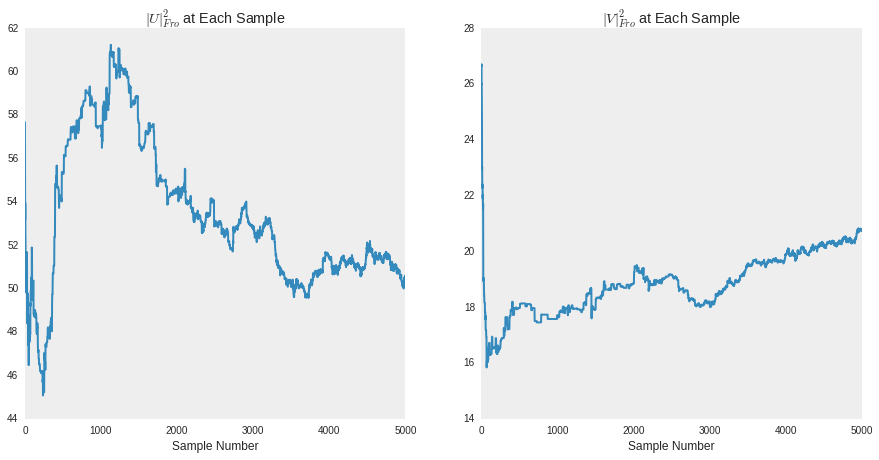

In [169]:
fbpmf.traceplot()

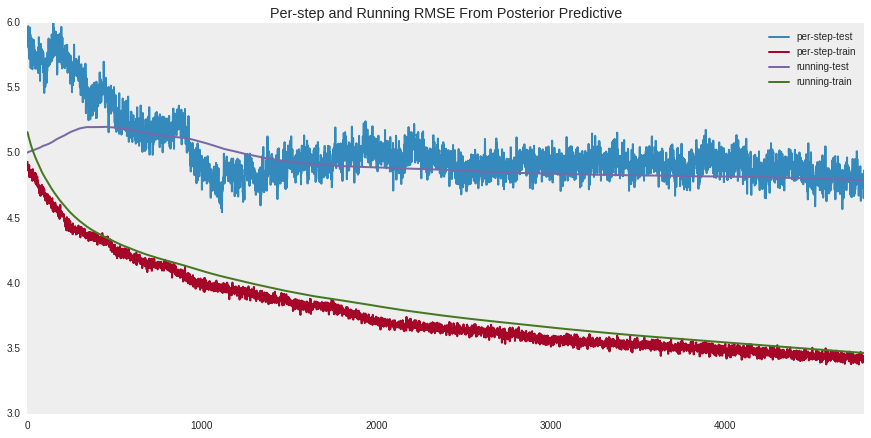

In [170]:
_, results_fbpmf = fbpmf.running_rmse(test, train, burn_in=200)

In [171]:
# Find MAP for FBPMF.
fbpmf.find_map()

INFO:root:finding PMF MAP using Powell optimization...
INFO:root:found PMF MAP in 1522 seconds
INFO:root:writing numpy vars to directory: data/bfpmf-map-d5


MAP was stored in data/mom folder


In [174]:
# Evaluate PMF MAP estimates.
fbpmf_map_rmse = fbpmf.eval_map(train, test)
fbpmf_improvement = baselines['mom'] - fbpmf_map_rmse
print 'PMF MAP Improvement:   %.5f' % fbpmf_improvement

PMF MAP training RMSE: 3.30869
PMF MAP testing RMSE:  4.77023
Train/test difference: 1.46154
PMF MAP Improvement:   -0.00970


In [175]:
# And our final RMSE?
fbpmb_final_test_rmse = results_fbpmf['running-test'].values[-1]
fbpmb_final_train_rmse = results_fbpmf['running-train'].values[-1]
print 'Posterior predictive train RMSE: %.5f' % fbpmb_final_train_rmse
print 'Posterior predictive test RMSE:  %.5f' % fbpmb_final_test_rmse
print 'Train/test difference:           %.5f' % (fbpmb_final_test_rmse - fbpmb_final_train_rmse)
print 'Improvement from MAP:            %.5f' % (fbpmf_map_rmse - fbpmb_final_test_rmse)
print 'Improvement from Mean of Means:  %.5f' % (baselines['mom'] - fbpmb_final_test_rmse)

Posterior predictive train RMSE: 3.46717
Posterior predictive test RMSE:  4.79397
Train/test difference:           1.32679
Improvement from MAP:            -0.02374
Improvement from Mean of Means:  -0.03345


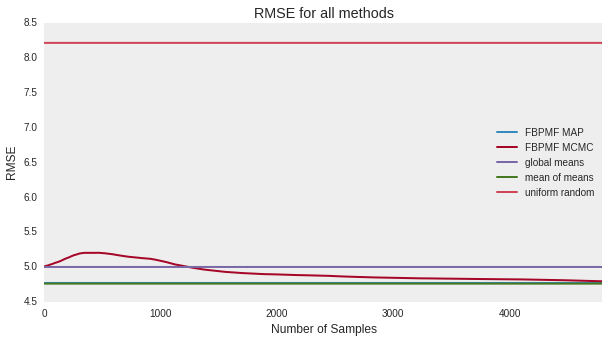

In [176]:
# let's plot results   
size = 4800
final_results = pd.DataFrame({
    'uniform random': np.repeat(baselines['ur'], size),
    'global means': np.repeat(baselines['gm'], size),
    'mean of means': np.repeat(baselines['mom'], size),
    'FBPMF MAP': np.repeat(fbpmf_map_rmse, size),
    'FBPMF MCMC': results_fbpmf['running-test'][:size]
        
})

fig, ax = plt.subplots(figsize=(10, 5))
final_results.plot(kind='line', grid=False, ax=ax,
                 title='RMSE for all methods')
ax.set_xlabel("Number of Samples")
ax.set_ylabel("RMSE")